In [156]:
import scipy
import numpy as np
import ringity as rng
import networkx as nx
import matplotlib.pyplot as plt

from numpy import pi as PI
from itertools import product
from scipy.spatial.distance import squareform

In [18]:
plt.style.use("fivethirtyeight")

In [19]:
def pdf_local_density(rho_i, a, rho, parameter, parameter_type):
    def costum_expected_node_degree(x):
        return rng.expected_node_degree(x, a=a, rho=rho, 
                                        parameter=parameter, parameter_type=parameter_type)
    def costum_d_expected_node_degree(x):
        return rng.d_expected_node_degree(x, a=a, rho=rho, 
                                          parameter=parameter, parameter_type=parameter_type)
    
    result = 0
    
    theta_max = rng.get_max_expectancy(a, parameter=beta, parameter_type=parameter_type)
    theta_min = rng.get_min_expectancy(a, parameter=beta, parameter_type=parameter_type)
    
    rho_max = costum_expected_node_degree(theta_max)
    rho_min = costum_expected_node_degree(theta_min)
    
    rho_left  = costum_expected_node_degree(0.)
    rho_right = costum_expected_node_degree(2*PI)
    
    
    if rho_left <= rho_i <= rho_max:
        theta = scipy.optimize.toms748(lambda x: costum_expected_node_degree(x)-rho_i, 
                                       0., theta_max)
        value = rng.pdf_delay(theta, parameter=parameter, parameter_type=parameter_type)
        result += value / abs(costum_d_expected_node_degree(theta))
        
    if rho_min <= rho_i <= rho_max:
        theta = scipy.optimize.toms748(lambda x: costum_expected_node_degree(x)-rho_i, 
                                       theta_max, theta_min)
        value = rng.pdf_delay(theta, parameter=parameter, parameter_type=parameter_type)
        result += value / abs(costum_d_expected_node_degree(theta))
        
    if rho_min <= rho_i <= rho_right:
        theta = scipy.optimize.toms748(lambda x: costum_expected_node_degree(x)-rho_i, 
                                       theta_min, 2*PI)
        value = rng.pdf_delay(theta, parameter=parameter, parameter_type=parameter_type)
        result += value / abs(costum_d_expected_node_degree(theta))
        
    return result

In [38]:
def deg_distribution(k, N, a, rho, parameter, parameter_type):
    def costum_expected_node_degree(x):
        return rng.expected_node_degree(x, a=a, rho=rho, 
                                        parameter=parameter, parameter_type=parameter_type)
    
    theta_max = rng.get_max_expectancy(a, parameter=parameter, parameter_type=parameter_type)
    theta_min = rng.get_min_expectancy(a, parameter=parameter, parameter_type=parameter_type)
    
    rho_max = costum_expected_node_degree(theta_max)
    rho_min = costum_expected_node_degree(theta_min)
    
    return scipy.integrate.quad(lambda rho_i:
                                   pdf_local_density(rho_i, a=a, rho=rho, 
                                                   parameter=parameter, 
                                                   parameter_type = parameter_type) * \
                                   scipy.stats.poisson.pmf(k, (N-1)*rho_i),
                                rho_min,rho_max)[0]

In [21]:
def simulated_local_density(a, rho, parameter, parameter_type):
    delays = rng.get_delays(N=2**10, param=parameter, parameter_type=parameter_type)
    return np.array([rng.expected_node_degree(theta, a=a, rho=rho, parameter=beta, parameter_type='delay')
                         for theta in delays])

In [22]:
rho  = 0.05
beta = 0.99
a    = 0.1

In [23]:
N = 2**8

In [24]:
obs_degs = []
obs_weig = []

ensemble_size = 2**8

for i in range(ensemble_size):
    print(f"{100*(i+1)/ensemble_size:.2f}%", end='\r')
    delas = rng.get_delays(N, beta)
    dists = rng.delays_to_distances(delas)
    simis = rng.distances_to_similarities(dists, a=a)
    probs = rng.similarities_to_probabilities(simis, a=a, rho=rho, param=beta, parameter_type = 'delay')
    degs = squareform(probs > np.random.uniform(size=N*(N-1)//2)).sum(axis=0)

    obs_degs.append(degs)
    obs_weig.append(probs)
    
obs_degs = np.array(obs_degs).flatten()
obs_weig = np.array(obs_weig).flatten()

In [25]:
#exp_degs = np.array([scipy.stats.poisson.rvs((N-1)*rho_i) 
#                         for rho_i in simulated_local_density(a=a, rho=rho, 
#                                                              parameter=beta, parameter_type='delay')])

# exp_degs = np.array([scipy.stats.binom.rvs(N-1, rho_i) 
#                          for rho_i in simulated_local_density(a=a, rho=rho, 
#                                                               parameter=beta, parameter_type='delay')])

In [39]:
%%time

k = np.linspace(min((min(exp_degs), min(obs_degs))), 
                max((max(exp_degs), max(obs_degs))),
                10, dtype=int)

degs = [deg_distribution(ki, N, a, rho, parameter=beta, parameter_type='delay') for ki in k]

<ipython-input-38-58da9c00606e>:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(lambda rho_i:


CPU times: user 22.6 s, sys: 187 ms, total: 22.8 s
Wall time: 22.7 s


In [40]:
annotation_str = fr"""$\rho = {rho:.3f}$
$\beta = {beta:.3f}$
$a = {a:.3f}$
$N = {N}$"""

In [41]:
freqs, degs = np.histogram(exp_degs, density=True, bins= (max(exp_degs)-min(exp_degs)))
degs = [(a+b)/2 for (a,b) in zip(degs[1:],degs[:-1])]

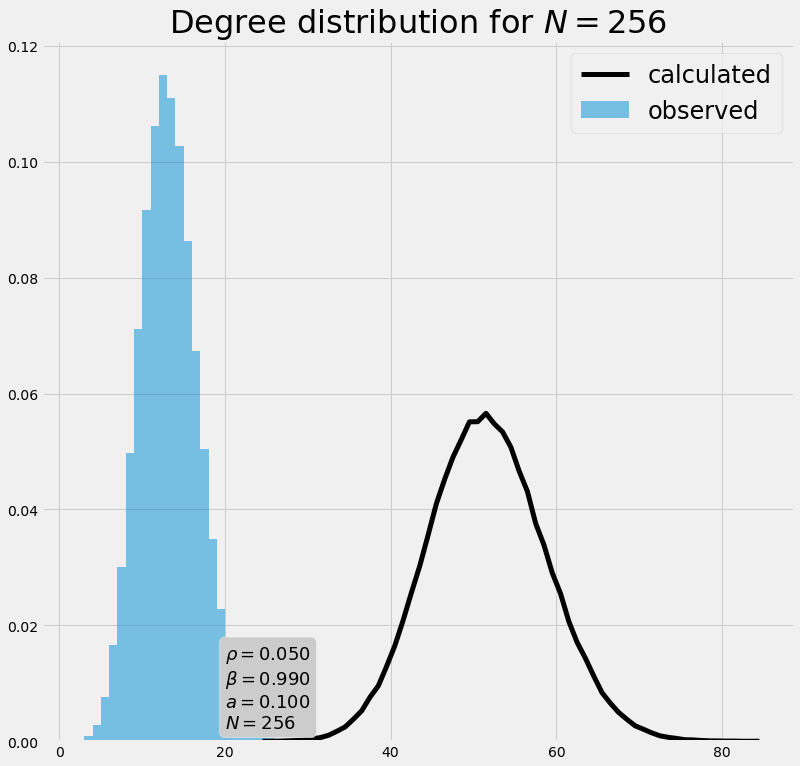

In [42]:
nb_bins_obs = (max(obs_degs)-min(obs_degs))
nb_bins_exp = (max(exp_degs)-min(exp_degs))

fig, ax = plt.subplots(figsize=(12,12))

ax.hist(obs_degs, bins=nb_bins_obs//1, density=True, alpha=0.5, label='observed');
#ax.hist(exp_degs, bins=nb_bins_exp//1, density=True, alpha=0.5, label='simulated');
ax.plot(degs, freqs, linewidth=5, c='k', label='calculated')

ax.set_title(f'Degree distribution for $N={N}$', fontsize=32)
ax.legend(fontsize=24)

ax.annotate(annotation_str, (20, 0.00225), 
            fontsize=18, bbox=dict(boxstyle="round", fc="0.8"))
fig.savefig("/Users/dottolab/Desktop/figs/fig3g.pdf")

## Combined plot

In [90]:
rho = 0.1
beta = 0.05
rate = rng.get_rate_parameter(beta, 'delay')

a = np.linspace(0,0.5,200)
rho_max = 1-np.sinh((PI-2*a*PI)*rate)/np.sinh(PI*rate)
a_back = (PI*rate - np.arcsinh((1 - rho_max)*np.sinh(PI*rate)))/(2*PI*rate)

In [109]:
a = np.linspace(0,0.5,200)
rho_max = 1-np.sinh((PI-2*a*PI)*rate)/np.sinh(PI*rate)
a_back = (PI*rate - np.arcsinh((1 - rho_max)*np.sinh(PI*rate)))/(2*PI*rate)

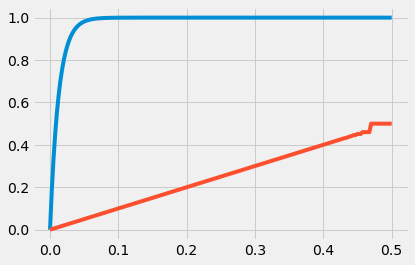

In [110]:
plt.plot(a, rho_max)
plt.plot(a, a_back)

In [111]:
rho


0.05

beta = 0.01
   a = 0.02
--------------------


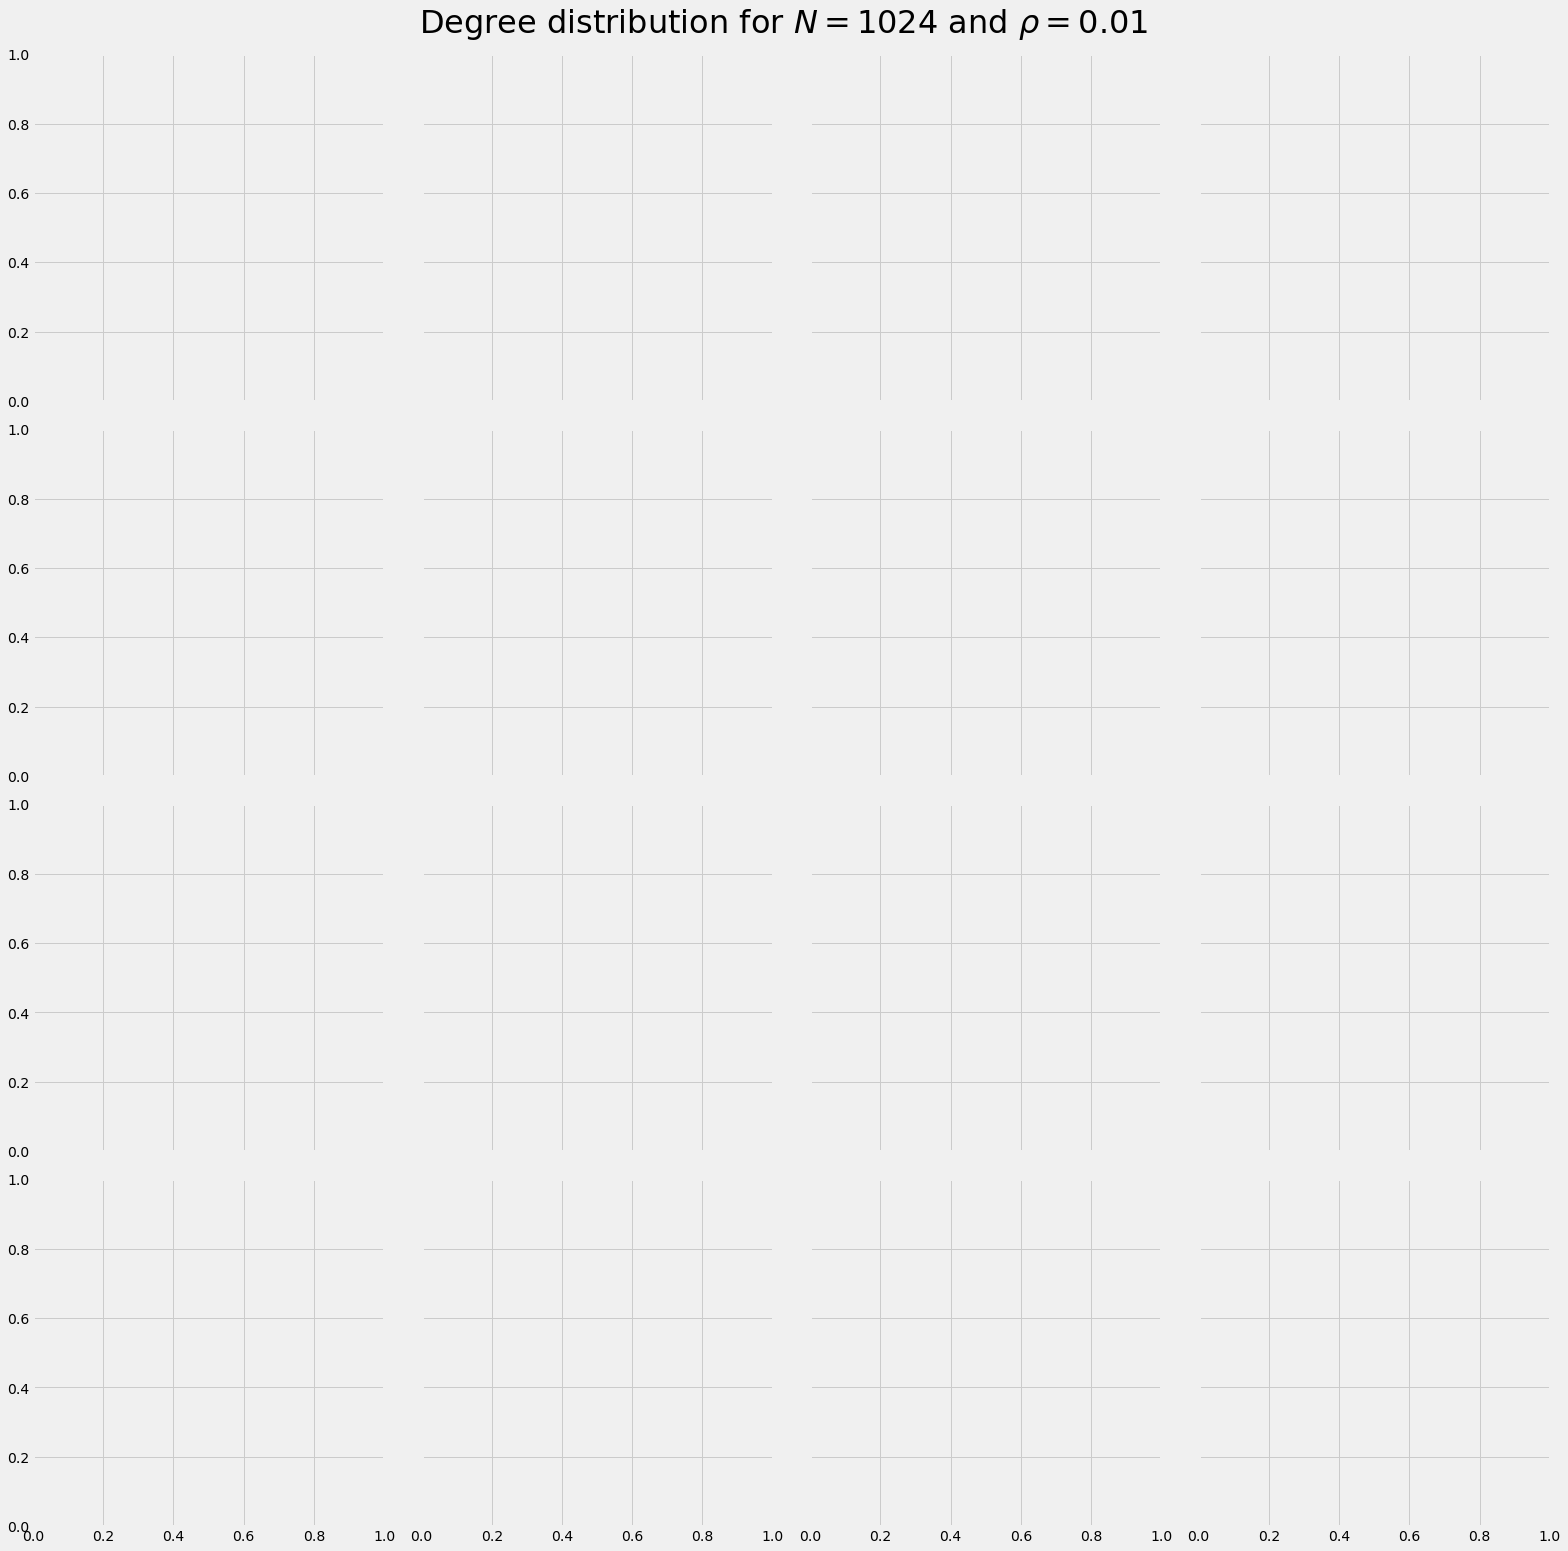

In [152]:
ensemble_size = 2**8

N = 2**10
rho = 0.01

nr_a    = 4
nr_beta = 4

fig, axes = plt.subplots(nr_beta, nr_a, figsize=(22,22), sharey=True, sharex=True)

for beta_i,beta in enumerate(np.linspace(0.01,0.99, nr_beta)):
    rate = rng.get_rate_parameter(beta, 'delay')
    if beta < 0.05:
        a_min = beta
    else:
        a_min = (PI*rate - np.arcsinh((1 - rho)*np.sinh(PI*rate)))/(2*PI*rate)
        
    for a_i,a in enumerate(np.linspace(a_min+0.01, 0.5, nr_a)):
        obs_degs = []
        obs_weig = []
        
        print(f"beta = {beta:.2f}")
        print(f"   a = {   a:.2f}")
        
        score_list = []
        
        for i in range(ensemble_size):
            print(f"{100*(i+1)/ensemble_size:.2f}%", end='\r')
            delas = rng.get_delays(N, beta)
            dists = rng.delays_to_distances(delas)
            simis = rng.distances_to_similarities(dists, a=a)
            probs = rng.similarities_to_probabilities(simis, a=a, rho=rho, param=beta, parameter_type = 'delay')
            A = (probs > np.random.uniform(size=N*(N-1)//2))
            degs = squareform(probs > np.random.uniform(size=N*(N-1)//2)).sum(axis=0)

            obs_degs.append(degs)
            obs_weig.append(probs)
        
        print(20*'-')
        break
        obs_degs = np.array(obs_degs).flatten()
        obs_weig = np.array(obs_weig).flatten()
        
        annotation_str = fr"""$\beta = {beta:.3f}$
$a = {a:.3f}$"""
        
        freqs, degs = np.histogram(exp_degs, density=True, bins= (max(exp_degs)-min(exp_degs)))
        degs = [(a+b)/2 for (a,b) in zip(degs[1:],degs[:-1])]
        
        nb_bins_obs = (max(obs_degs)-min(obs_degs))
        nb_bins_exp = (max(exp_degs)-min(exp_degs))


        axes[beta_i, a_i].hist(obs_degs, bins=nb_bins_obs//1, density=True, alpha=0.5, label='observed');
#         ax.hist(exp_degs, bins=nb_bins_exp//1, density=True, alpha=0.5, label='simulated');
#         ax.plot(degs, freqs, linewidth=5, c='k', label='calculated')

        axes[beta_i, a_i].legend(fontsize=24)

        axes[beta_i, a_i].annotate(annotation_str, (20, 0.00225), 
                    fontsize=18, bbox=dict(boxstyle="round", fc="0.8"))
    break
fig.suptitle(fr'Degree distribution for $N={N}$ and $\rho = {rho:.2f}$', fontsize=32)
fig.tight_layout()
plt.gcf().subplots_adjust(top=0.95)
fig.savefig("/Users/dottolab/Desktop/ringity_meeting/tmp1.pdf")

In [157]:
G = nx.from_numpy_array(squareform(A))

In [158]:
score = rng.diagram(G).score

DisconnectedGraphError: 

beta = 0.01
   a = 0.02
--------------------
beta = 0.01
   a = 0.18
--------------------
beta = 0.01
   a = 0.34
--------------------
beta = 0.01
   a = 0.50
--------------------
beta = 0.34
   a = 0.01
--------------------
beta = 0.34
   a = 0.18
--------------------
beta = 0.34
   a = 0.34
--------------------
beta = 0.34
   a = 0.50
--------------------
beta = 0.66
   a = 0.02
--------------------
beta = 0.66
   a = 0.18
--------------------
beta = 0.66
   a = 0.34
--------------------
beta = 0.66
   a = 0.50
--------------------
beta = 0.99
   a = 0.03
--------------------
beta = 0.99
   a = 0.19
--------------------
beta = 0.99
   a = 0.34
--------------------
beta = 0.99
   a = 0.50
--------------------


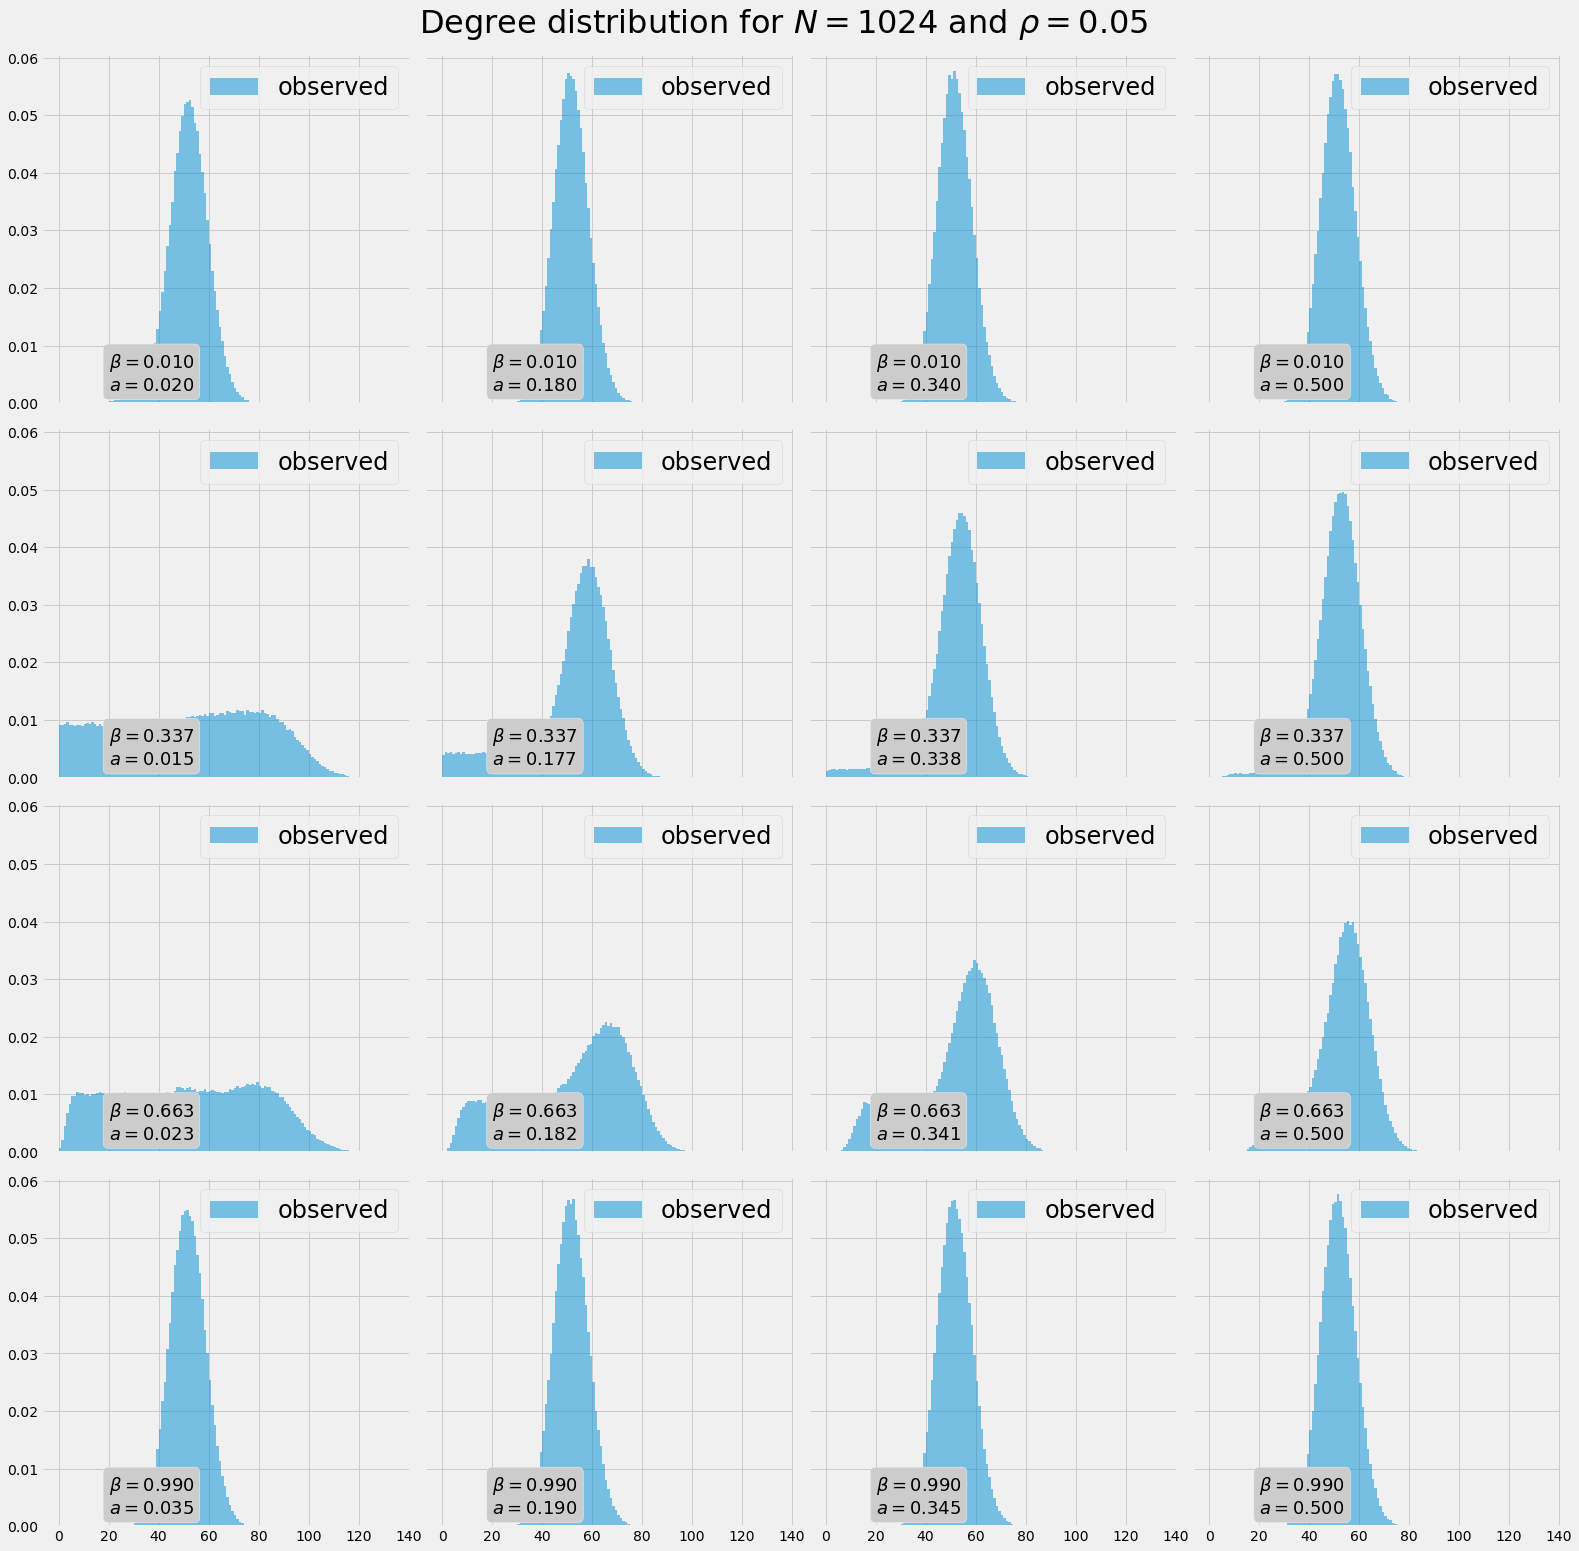

In [149]:
ensemble_size = 2**8

N = 2**10
rho = 0.05

nr_a    = 4
nr_beta = 4

fig, axes = plt.subplots(nr_beta, nr_a, figsize=(22,22), sharey=True, sharex=True)

for beta_i,beta in enumerate(np.linspace(0.01,0.99, nr_beta)):
    rate = rng.get_rate_parameter(beta, 'delay')
    if beta < 0.05:
        a_min = beta
    else:
        a_min = (PI*rate - np.arcsinh((1 - rho)*np.sinh(PI*rate)))/(2*PI*rate)
        
    for a_i,a in enumerate(np.linspace(a_min+0.01, 0.5, nr_a)):
        obs_degs = []
        obs_weig = []
        
        print(f"beta = {beta:.2f}")
        print(f"   a = {   a:.2f}")
        
        for i in range(ensemble_size):
            print(f"{100*(i+1)/ensemble_size:.2f}%", end='\r')
            delas = rng.get_delays(N, beta)
            dists = rng.delays_to_distances(delas)
            simis = rng.distances_to_similarities(dists, a=a)
            probs = rng.similarities_to_probabilities(simis, a=a, rho=rho, param=beta, parameter_type = 'delay')
            degs = squareform(probs > np.random.uniform(size=N*(N-1)//2)).sum(axis=0)

            obs_degs.append(degs)
            obs_weig.append(probs)
        
        print(20*'-')
        
        obs_degs = np.array(obs_degs).flatten()
        obs_weig = np.array(obs_weig).flatten()
        
        annotation_str = fr"""$\beta = {beta:.3f}$
$a = {a:.3f}$"""
        
        freqs, degs = np.histogram(exp_degs, density=True, bins= (max(exp_degs)-min(exp_degs)))
        degs = [(a+b)/2 for (a,b) in zip(degs[1:],degs[:-1])]
        
        nb_bins_obs = (max(obs_degs)-min(obs_degs))
        nb_bins_exp = (max(exp_degs)-min(exp_degs))


        axes[beta_i, a_i].hist(obs_degs, bins=nb_bins_obs//1, density=True, alpha=0.5, label='observed');
#         ax.hist(exp_degs, bins=nb_bins_exp//1, density=True, alpha=0.5, label='simulated');
#         ax.plot(degs, freqs, linewidth=5, c='k', label='calculated')

        axes[beta_i, a_i].legend(fontsize=24)

        axes[beta_i, a_i].annotate(annotation_str, (20, 0.00225), 
                    fontsize=18, bbox=dict(boxstyle="round", fc="0.8"))

fig.suptitle(fr'Degree distribution for $N={N}$ and $\rho = {rho:.2f}$', fontsize=32)
fig.tight_layout()
plt.gcf().subplots_adjust(top=0.95)
fig.savefig("/Users/dottolab/Desktop/ringity_meeting/fig1.pdf")

beta = 0.01
   a = 0.02
--------------------
beta = 0.01
   a = 0.18
--------------------
beta = 0.01
   a = 0.34
--------------------
beta = 0.01
   a = 0.50
--------------------
beta = 0.34
   a = 0.01
--------------------
beta = 0.34
   a = 0.17
--------------------
beta = 0.34
   a = 0.34
--------------------
beta = 0.34
   a = 0.50
--------------------
beta = 0.66
   a = 0.01
--------------------
beta = 0.66
   a = 0.18
--------------------
beta = 0.66
   a = 0.34
--------------------
beta = 0.66
   a = 0.50
--------------------
beta = 0.99
   a = 0.01
--------------------
beta = 0.99
   a = 0.18
--------------------
beta = 0.99
   a = 0.34
--------------------
beta = 0.99
   a = 0.50
--------------------


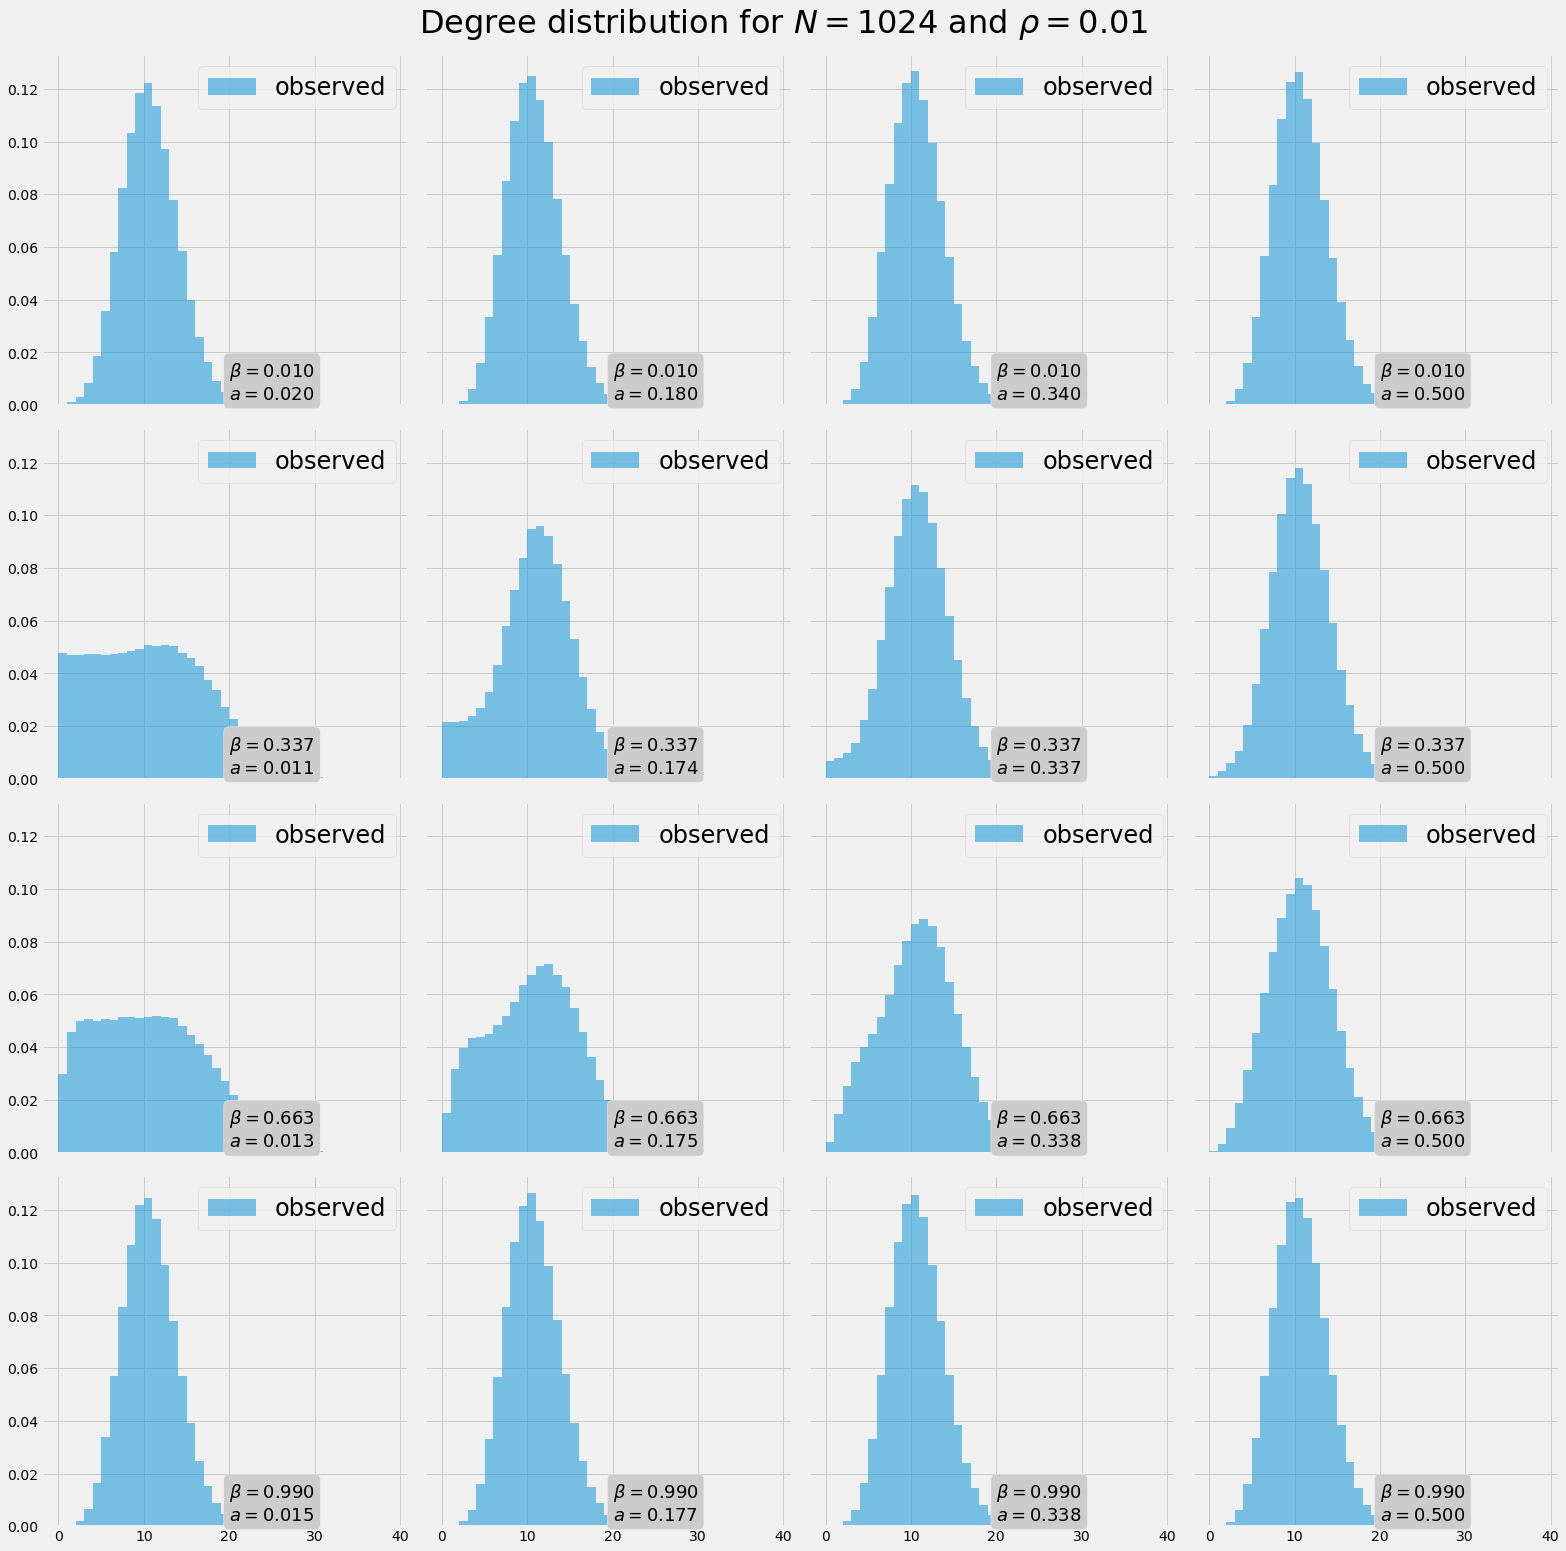

In [150]:
ensemble_size = 2**8

N = 2**10
rho = 0.01

nr_a    = 4
nr_beta = 4

fig, axes = plt.subplots(nr_beta, nr_a, figsize=(22,22), sharey=True, sharex=True)

for beta_i,beta in enumerate(np.linspace(0.01,0.99, nr_beta)):
    rate = rng.get_rate_parameter(beta, 'delay')
    if beta < 0.05:
        a_min = beta
    else:
        a_min = (PI*rate - np.arcsinh((1 - rho)*np.sinh(PI*rate)))/(2*PI*rate)
        
    for a_i,a in enumerate(np.linspace(a_min+0.01, 0.5, nr_a)):
        obs_degs = []
        obs_weig = []
        
        print(f"beta = {beta:.2f}")
        print(f"   a = {   a:.2f}")
        
        for i in range(ensemble_size):
            print(f"{100*(i+1)/ensemble_size:.2f}%", end='\r')
            delas = rng.get_delays(N, beta)
            dists = rng.delays_to_distances(delas)
            simis = rng.distances_to_similarities(dists, a=a)
            probs = rng.similarities_to_probabilities(simis, a=a, rho=rho, param=beta, parameter_type = 'delay')
            degs = squareform(probs > np.random.uniform(size=N*(N-1)//2)).sum(axis=0)

            obs_degs.append(degs)
            obs_weig.append(probs)
        
        print(20*'-')
        
        obs_degs = np.array(obs_degs).flatten()
        obs_weig = np.array(obs_weig).flatten()
        
        annotation_str = fr"""$\beta = {beta:.3f}$
$a = {a:.3f}$"""
        
        freqs, degs = np.histogram(exp_degs, density=True, bins= (max(exp_degs)-min(exp_degs)))
        degs = [(a+b)/2 for (a,b) in zip(degs[1:],degs[:-1])]
        
        nb_bins_obs = (max(obs_degs)-min(obs_degs))
        nb_bins_exp = (max(exp_degs)-min(exp_degs))


        axes[beta_i, a_i].hist(obs_degs, bins=nb_bins_obs//1, density=True, alpha=0.5, label='observed');
#         ax.hist(exp_degs, bins=nb_bins_exp//1, density=True, alpha=0.5, label='simulated');
#         ax.plot(degs, freqs, linewidth=5, c='k', label='calculated')

        axes[beta_i, a_i].legend(fontsize=24)

        axes[beta_i, a_i].annotate(annotation_str, (20, 0.00225), 
                    fontsize=18, bbox=dict(boxstyle="round", fc="0.8"))

fig.suptitle(fr'Degree distribution for $N={N}$ and $\rho = {rho:.2f}$', fontsize=32)
fig.tight_layout()
plt.gcf().subplots_adjust(top=0.95)
fig.savefig("/Users/dottolab/Desktop/ringity_meeting/fig3.pdf")

In [101]:
a_min

array([0.        , 0.00251256, 0.00502513, 0.00753769, 0.01005025,
       0.01256281, 0.01507538, 0.01758794, 0.0201005 , 0.02261307,
       0.02512563, 0.02763819, 0.03015075, 0.03266332, 0.03517588,
       0.03768844, 0.04020101, 0.04271357, 0.04522613, 0.04773869,
       0.05025126, 0.05276382, 0.05527638, 0.05778894, 0.06030151,
       0.06281407, 0.06532663, 0.0678392 , 0.07035176, 0.07286432,
       0.07537688, 0.07788945, 0.08040201, 0.08291457, 0.08542714,
       0.0879397 , 0.09045226, 0.09296482, 0.09547739, 0.09798995,
       0.10050251, 0.10301508, 0.10552764, 0.1080402 , 0.11055276,
       0.11306533, 0.11557789, 0.11809045, 0.12060302, 0.12311558,
       0.12562814, 0.1281407 , 0.13065327, 0.13316583, 0.13567839,
       0.13819095, 0.14070352, 0.14321608, 0.14572864, 0.14824121,
       0.15075377, 0.15326633, 0.15577889, 0.15829146, 0.16080402,
       0.16331658, 0.16582915, 0.16834171, 0.17085427, 0.17336683,
       0.1758794 , 0.17839196, 0.18090452, 0.18341709, 0.18592

In [100]:
next(enumerate(np.linspace(a_min, 0.5, nr_a)))

TypeError: enumerate() takes at most 2 arguments (3 given)